In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cosine
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.interpolate import interp1d

%matplotlib inline


In [2]:
# Cell B: loading functions
def load_experimental_csv(path, wcol=0, icol=1):
    """
    Load an experimental spectrum CSV. Return wavenumbers (x, descending) and intensities (y).
    Expects two columns: wavenumber, intensity .
    """
    df = pd.read_csv(path, comment='#', header=0)
    # allow header names detection
    cols = df.columns
    if 'wavenumber' in cols.str.lower() or 'wavenumber' in cols:
        x = df.iloc[:, 0].values
        y = df.iloc[:, 1].values
    else:
        x = df.iloc[:, wcol].values
        y = df.iloc[:, icol].values
    # ensure numpy arrays and descending x (IR convention)
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    if x[0] < x[-1]:
        x = x[::-1]
        y = y[::-1]
    return x, y

def load_computed_csv(path):
    """Load computed broadened CSV (Wavenumber, Intensity)."""
    return load_experimental_csv(path)


In [3]:
# Cell C: preprocessing
def subtract_baseline(y, method='min'):
    """Simple baseline removal strategies: 'min' or 'median' or None."""
    if method == 'min':
        return y - np.min(y)
    if method == 'median':
        return y - np.median(y)
    return y

def normalize(y, method='max'):
    if method == 'max':
        if y.max() == 0: 
            return y
        return y / np.max(y)
    if method == 'area':
        s = np.trapz(np.clip(y, 0, None))
        return y / s if s != 0 else y
    return y

def resample_to_grid(x_src, y_src, x_target):
    """Interpolate y_src(x_src) onto x_target (linear interpolation)."""
    f = interp1d(x_src, y_src, kind='linear', bounds_error=False, fill_value=0.0)
    return f(x_target)


In [4]:
# Cell D: metrics
def pearson(a, b):
    try:
        return pearsonr(a, b)[0]
    except:
        return np.nan

def spearman(a, b):
    try:
        return spearmanr(a, b).correlation
    except:
        return np.nan

def cosine_sim(a, b):
    if np.all(a==0) or np.all(b==0):
        return 0.0
    return 1.0 - cosine(a, b)

def spectral_overlap(a, b, x):
    denom = np.trapz(np.clip(a, 0, None), x)
    if denom == 0:
        return 0.0
    overlap = np.trapz(np.minimum(np.clip(a,0,None), np.clip(b,0,None)), x)
    return overlap / denom

def l1_rmse(a, b):
    a = np.array(a); b = np.array(b)
    mae = np.mean(np.abs(a - b))
    rmse = np.sqrt(np.mean((a - b)**2))
    return mae, rmse

def js_divergence(a, b, eps=1e-12):
    pa = np.clip(a, 0, None).astype(float)
    pb = np.clip(b, 0, None).astype(float)
    if pa.sum() == 0 or pb.sum() == 0:
        return np.nan
    pa = (pa + eps) / (pa.sum() + eps*len(pa))
    pb = (pb + eps) / (pb.sum() + eps*len(pb))
    m = 0.5*(pa+pb)
    return 0.5*(entropy(pa, m) + entropy(pb, m))

def wasserstein(a_weights, b_weights, x):
    # a_weights, b_weights must be non-negative and sum to >0; returns EMD
    if np.sum(a_weights)==0 or np.sum(b_weights)==0:
        return np.nan
    a_norm = a_weights / np.sum(a_weights)
    b_norm = b_weights / np.sum(b_weights)
    return wasserstein_distance(x, x, u_weights=a_norm, v_weights=b_norm)


In [5]:
# Cell F: compare and plot
def compare_and_plot(exp_path, comp_path,
                     grid_min=None, grid_max=None, step=1.0,
                     baseline='min', normalize_method='max',
                     shift_search=True, shift_range=(-30,30), shift_step=1.0):
    # load
    exp_x, exp_y = load_experimental_csv(exp_path)
    comp_x, comp_y = load_computed_csv(comp_path)

    # preprocessing
    exp_y = subtract_baseline(exp_y, method=baseline)
    comp_y = subtract_baseline(comp_y, method=baseline)

    # choose common grid
    if grid_min is None: grid_min = min(np.min(exp_x), np.min(comp_x)) - 10
    if grid_max is None: grid_max = max(np.max(exp_x), np.max(comp_x)) + 10
    grid = np.arange(grid_max, grid_min - step, -step)  # descending order

    exp_res = resample_to_grid(exp_x, exp_y, grid)
    comp_res = resample_to_grid(comp_x, comp_y, grid)

    # optional shift search (shifts comp_x)
    best_shift = 0.0
    if shift_search:
        s, _, comp_shifted_res = find_best_shift(grid, exp_res, grid, comp_res,
                                                shift_range=shift_range, step=shift_step, metric='rmse')
        best_shift = s
        comp_res = comp_shifted_res

    # normalize
    exp_norm = normalize(exp_res, method=normalize_method)
    comp_norm = normalize(comp_res, method=normalize_method)

    # metrics
    p = pearson(exp_norm, comp_norm)
    s = spearman(exp_norm, comp_norm)
    cos = cosine_sim(exp_norm, comp_norm)
    overlap = spectral_overlap(exp_norm, comp_norm, grid)
    l1, rmse = l1_rmse(exp_norm, comp_norm)
    js = js_divergence(exp_norm, comp_norm)
    wd = wasserstein(exp_norm, comp_norm, grid)

    metrics = {
        'pearson': p, 'spearman': s, 'cosine': cos,
        'overlap': overlap, 'mae': l1, 'rmse': rmse, 'js': js, 'wasserstein': wd,
        'best_shift_cm-1': best_shift
    }

    # plotting
    plt.figure(figsize=(10,4))
    plt.plot(grid, exp_norm, label='Experimental', linewidth=1.5)
    plt.plot(grid, comp_norm, label='Computed', linewidth=1.0, alpha=0.9)
    plt.gca().invert_xaxis()
    plt.xlabel('Wavenumber (cm$^{-1}$)')
    plt.ylabel('Normalized intensity')
    plt.title(f'Experimental vs Computed (shift={best_shift:.1f} cm$^{{-1}}$)')
    plt.legend()
    plt.show()

    # residual plot
    plt.figure(figsize=(10,2))
    plt.plot(grid, exp_norm - comp_norm)
    plt.gca().invert_xaxis()
    plt.xlabel('Wavenumber (cm$^{-1}$)')
    plt.ylabel('Residual (exp - calc)')
    plt.tight_layout()
    plt.show()

    return metrics, grid, exp_norm, comp_norm


C:\Users\SellIT\AppData\Local\Temp\ipykernel_16684\1449250633.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  denom = np.trapz(np.clip(a, 0, None), x)
C:\Users\SellIT\AppData\Local\Temp\ipykernel_16684\1449250633.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  overlap = np.trapz(np.minimum(np.clip(a,0,None), np.clip(b,0,None)), x)


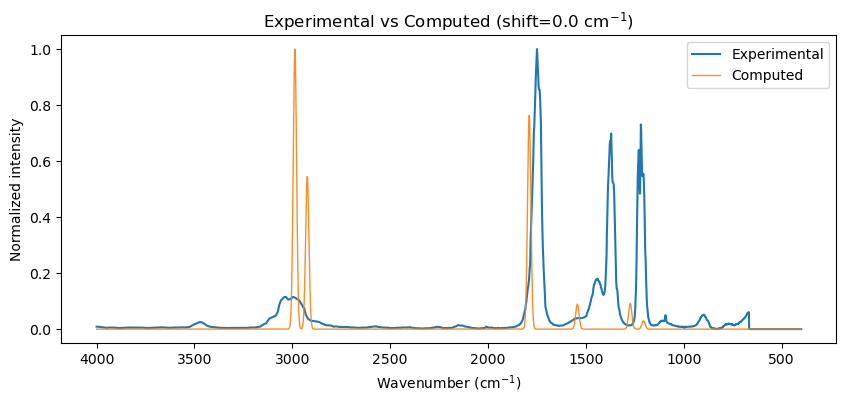

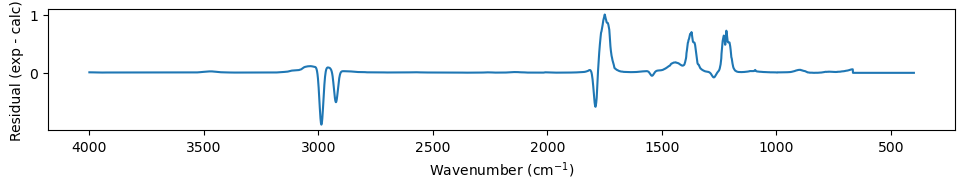

{'pearson': np.float64(0.1099559197093592), 'spearman': np.float64(0.548169287317341), 'cosine': np.float64(0.159473996552555), 'overlap': np.float64(0.09739035139577827), 'mae': np.float64(0.05276821301114858), 'rmse': np.float64(0.15044879659189625), 'js': np.float64(0.5078991936695367), 'wasserstein': np.float64(767.5851711943649), 'best_shift_cm-1': 0.0}


In [7]:
exp_path = r"spectra_CSV/Acetone_IR_Exp.csv"   
comp_path = r"spectra_CSV/Acetone_RI-B2PLYP_TZVP.csv"        

metrics, grid, exp_norm, comp_norm = compare_and_plot(
    exp_path, comp_path,
    grid_min=400, grid_max=4000, step=1.0,
    baseline='min', normalize_method='max',
    shift_search=False, shift_range=(-50,50), shift_step=1.0
)

print(metrics)
